In [9]:
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from scipy import sparse
from skimage import transform
from skimage.transform import resize
from error_propagation_radon_transform import utils
import tensorflow as tf

In [2]:
rsp = np.load('../../Data/simple_pCT/Phantoms/Head/RSP.npy')

In [3]:
scale = 1
phantom = np.pad(rsp[:,:,rsp.shape[2]//2], ((30*scale,30*scale), (100*scale, 100*scale)))

phantom = resize( phantom, (130, 130), anti_aliasing=True )

x = phantom.flatten()
RSP_shape = phantom.shape[:2]
print(RSP_shape)

(130, 130)


In [4]:
num_angles = 179
num_offsets = 30
num_spotxs = 190
MLP_angles_spotx = sparse.load_npz('../../Data/simple_pCT/MLP/MLP_angles{:d}_offset{:d}_spotx{:d}_exact_{:d}_{:d}.npz'.format(num_angles, num_offsets, num_spotxs, RSP_shape[0], RSP_shape[1]))
print(MLP_angles_spotx.shape)

(1020300, 16900)


In [5]:
numberOfSamples = 50

i1, _, i3 = np.indices((num_spotxs, numberOfSamples, num_angles))

rng = np.random.default_rng()
# mean of 15 and 99% are within 3 * std = 15
i2 = rng.normal(15, 5, (num_spotxs, numberOfSamples, num_angles)).astype(np.int64)
i2[ i2 < 0 ] = 0
i2[ i2 > num_offsets - 1 ] = num_offsets - 1

# i2 = np.random.randint(0, 30, size=(num_angles, num_offsets, num_spotxs))


idx = np.ravel_multi_index((i1, i2, i3), (num_spotxs, num_offsets, num_angles))

MLP_random = MLP_angles_spotx[idx.flatten(), :]

b_w = MLP_random @ x
wepl = np.reshape(b_w, (num_spotxs, numberOfSamples, num_angles))

In [6]:
np.save(f'../../Data/simple_pCT/WEPL/WEPL_ensemble_angles{num_angles}_offset{num_offsets}_spotx{num_spotxs}_exact_{RSP_shape[0]}_{RSP_shape[1]}.npy', wepl)

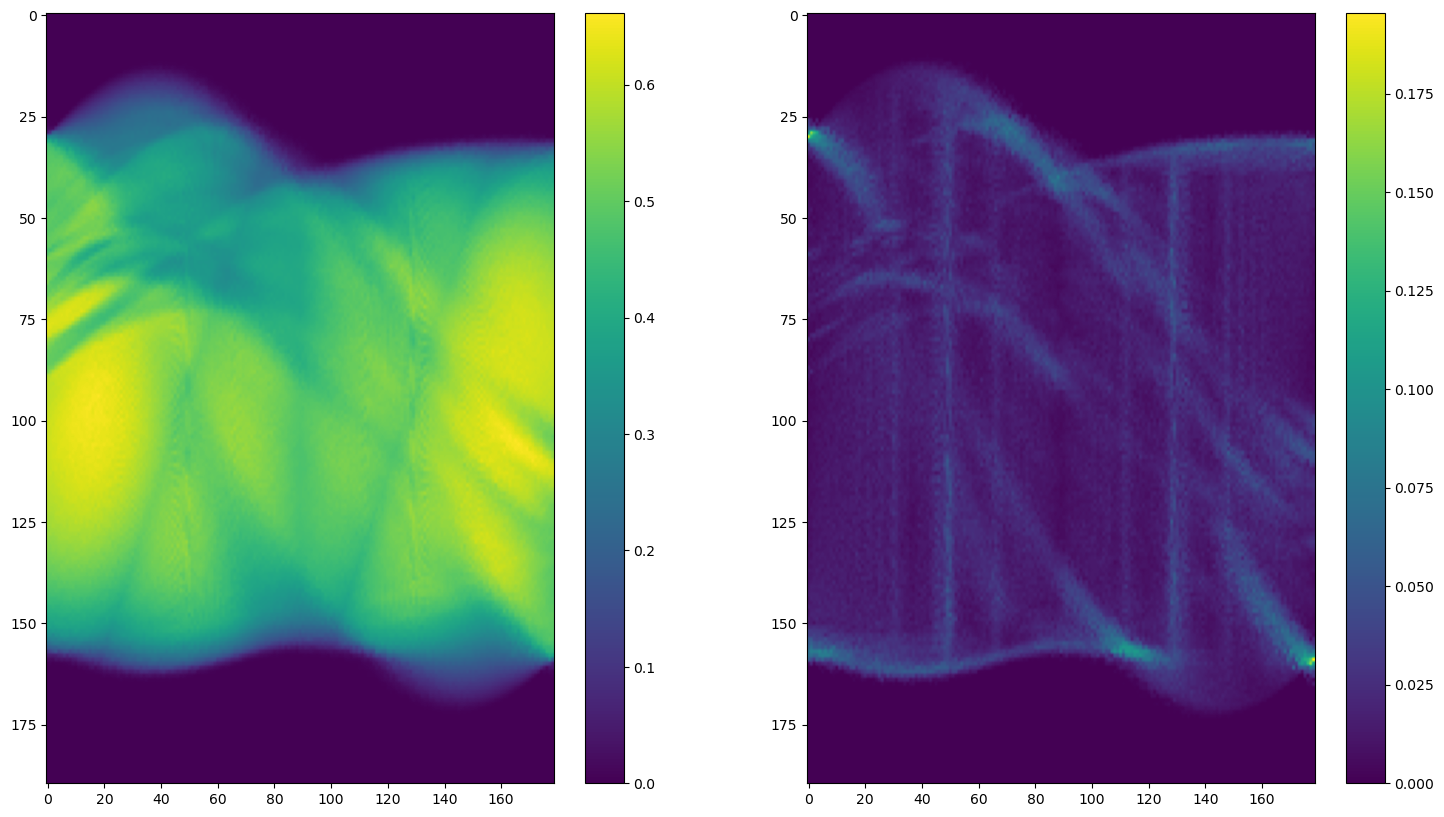

In [6]:
wepl_mean = np.mean(wepl, axis=1)
wepl_var = np.var(wepl, axis=1)

plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.imshow(wepl_mean, aspect='auto')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.sqrt(wepl_var), aspect='auto')
plt.colorbar()
plt.show()

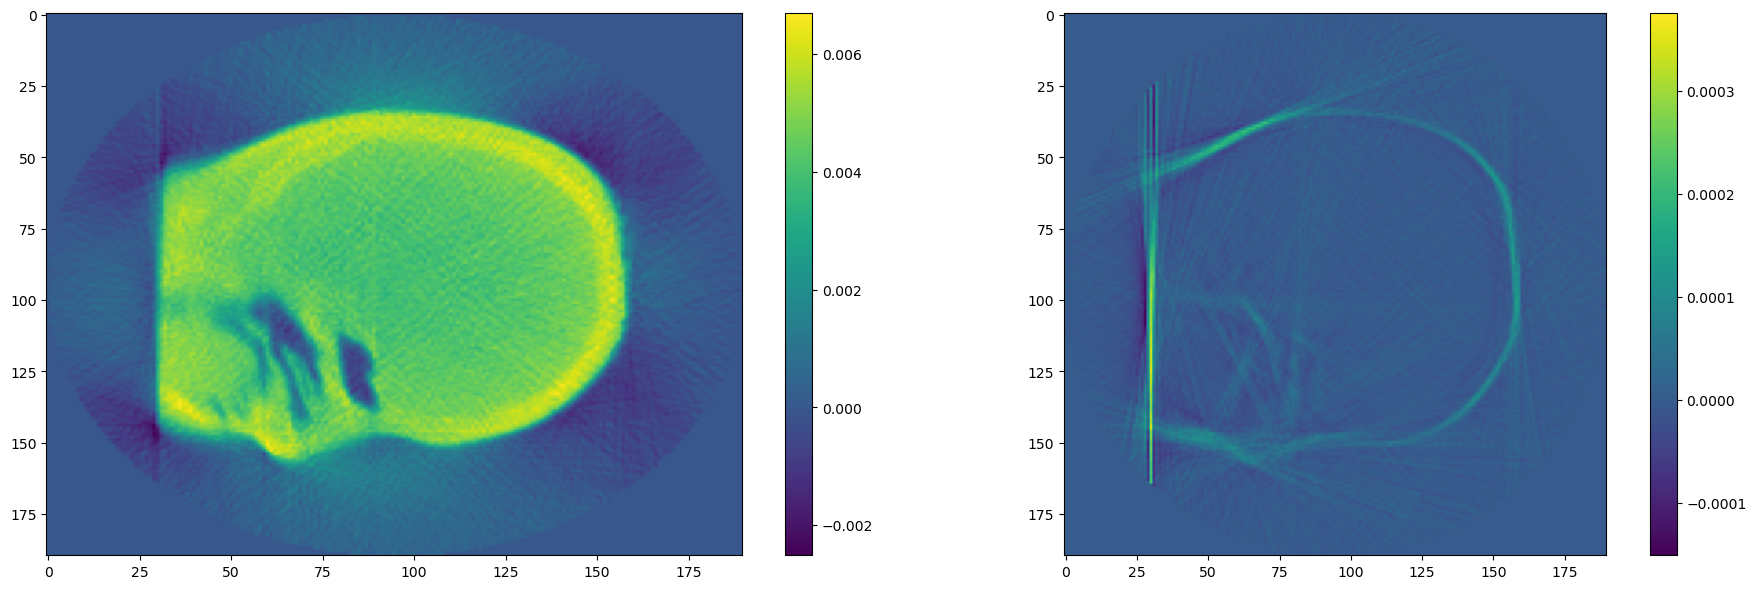

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

theta = np.linspace(0., 180., num_angles, endpoint=False)
reconstructed_mean = transform.iradon(wepl_mean, theta=theta, filter_name='ramp', circle=True)
sin = ax1.imshow(reconstructed_mean, aspect='auto')
plt.colorbar(sin, ax=ax1)

reconstructed_var = transform.iradon(wepl_var, theta=theta, filter_name='ramp', circle=True)
re = ax2.imshow(reconstructed_var)
plt.colorbar(re, ax=ax2)

fig.tight_layout()
plt.show()

In [17]:
np.save('../../Data/simple_pCT/WEPL/WEPL_angles{:d}_offset{:d}_spotx{:d}_exact_{:d}_{:d}.npy'.format(num_angles, num_offsets, num_spotxs, RSP_shape[0], RSP_shape[1]), wepl)